In [2]:
import numpy as np
import MDAnalysis as md
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from 

ModuleNotFoundError: No module named 'vonMisesMixtureModel'

In [80]:
coord = md.Universe("diala_vacuum.parm7","md_wrapped.nc", "md_1_wrapped.nc")
print("Number of frames:", coord.trajectory.n_frames)
# select protein
protein = coord.select_atoms("protein")
# Calculate phi and psi angles for each residue
# selection of atomgroups
phi_sel = [coord.residues[1].phi_selection()]
psi_sel = [coord.residues[1].psi_selection()]

from MDAnalysis.analysis.dihedrals import Dihedral
phi = Dihedral(phi_sel).run()
psi = Dihedral(psi_sel).run()

# format data for MultiSineBVVMMM
phi_psi = np.column_stack((phi.results.angles,psi.results.angles)).reshape(-1,1,2)

Number of frames: 3000000


In [39]:
# Estimate parameters from the sample data
estimated_mu, estimated_kappa = estimate_von_mises_params(np.radians(phi.results.angles))

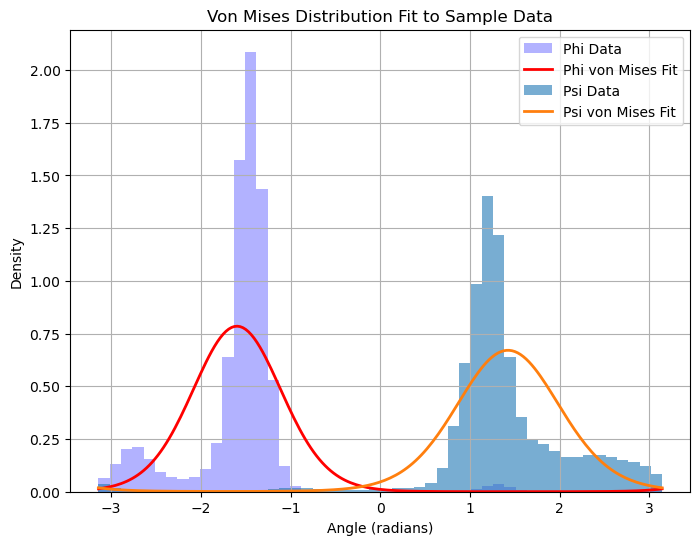

In [42]:
from scipy.stats import vonmises
# Generate a smooth curve for the estimated von Mises distribution
theta = np.linspace(-np.pi, np.pi, 200)  # Angle range from -π to π


# Plot histogram of sample data
plt.figure(figsize=(8, 6))
# plot phi
plt.hist(np.radians(phi.results.angles), bins=50, density=True, alpha=0.3, color='b', label="Phi Data")
# Estimate parameters from the sample data
estimated_mu, estimated_kappa = estimate_von_mises_params(np.radians(phi.results.angles))
## Plot estimated von Mises PDF
fitted_pdf = vonmises.pdf(theta, estimated_kappa, loc=estimated_mu)
plt.plot(theta, fitted_pdf, 'r-', lw=2, label="Phi von Mises Fit")

plt.hist(np.radians(psi.results.angles), bins=50, density=True, alpha=0.6, label="Psi Data")
# Estimate parameters from the sample data
estimated_mu, estimated_kappa = estimate_von_mises_params(np.radians(psi.results.angles))
# Plot estimated von Mises PDF
fitted_pdf = vonmises.pdf(theta, estimated_kappa, loc=estimated_mu)
plt.plot(theta, fitted_pdf, lw=2, label="Psi von Mises Fit")

# Formatting the plot
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Von Mises Distribution Fit to Sample Data")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [31]:
np.savetxt("phi.dat", phi.results.angles)

In [31]:
# Optimized version of the Von Mises Mixture Model using EM
from scipy.special import i0

class VonMisesMixtureEM:
    def __init__(self, n_components, max_iter=100, tol=1e-6):
        self.n_components = n_components  # Number of von Mises components
        self.max_iter = max_iter  # Maximum iterations for EM
        self.tol = tol  # Convergence threshold
        self.weights = None  # Mixture weights
        self.means = None  # Mean directions (mu)
        self.kappas = None  # Concentration parameters

    def initialize_parameters(self, data):
        """ Initialize parameters using random selection """
        self.weights = np.ones(self.n_components) / self.n_components  # Equal weights initially
        self.means = np.random.choice(data, self.n_components, replace=False)  # Random initial means
        self.kappas = np.full(self.n_components, 1.0)  # Initial kappas set to 1

    def von_mises_pdf(self, x, mu, kappa):
        """ Compute the von Mises PDF efficiently """
        return np.exp(kappa * np.cos(x - mu)) / (2 * np.pi * i0(kappa))

    def e_step(self, data):
        """ Expectation step: compute responsibilities """
        n = len(data)
        responsibilities = np.zeros((n, self.n_components))

        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self.von_mises_pdf(data, self.means[k], self.kappas[k])
        
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)  # Normalize
        return responsibilities

    def m_step(self, data, responsibilities):
        """ Maximization step: update parameters """
        n_k = responsibilities.sum(axis=0)  # Effective number of points for each component

        # Update weights
        self.weights = n_k / len(data)

        # Update means (mu) using circular mean
        for k in range(self.n_components):
            C_k = np.sum(responsibilities[:, k] * np.cos(data)) / n_k[k]
            S_k = np.sum(responsibilities[:, k] * np.sin(data)) / n_k[k]
            self.means[k] = np.arctan2(S_k, C_k)

            # Update kappa using an approximation
            R_k = np.sqrt(C_k**2 + S_k**2)
            if R_k < 0.53:
                self.kappas[k] = 2 * R_k + R_k**3 + (5 / 6) * R_k**5
            elif 0.53 <= R_k < 0.85:
                self.kappas[k] = -0.4 + 1.39 * R_k + 0.43 / (1 - R_k)
            else:
                self.kappas[k] = 1 / (2 * (1 - R_k))

    def fit(self, data):
        """ Fit the von Mises mixture model using EM """
        self.initialize_parameters(data)
        prev_likelihood = -np.inf

        for iteration in range(self.max_iter):
            responsibilities = self.e_step(data)
            self.m_step(data, responsibilities)

            # Compute log-likelihood
            log_likelihood = np.sum(np.log(np.sum([self.weights[k] * self.von_mises_pdf(data, self.means[k], self.kappas[k])
                                                   for k in range(self.n_components)], axis=0)))

            # Check for convergence
            if np.abs(log_likelihood - prev_likelihood) < self.tol:
                break
            prev_likelihood = log_likelihood

        # determine cluster ids based on cluster with max likelihood
        cluster_ids = np.argmax(responsibilities,axis=1)
        
        return cluster_ids, log_likelihood
    
    def predict(self, data):
        """Predict cluster ids"""
        
        responsibilities = self.e_step(data)
        
        # determine cluster ids based on cluster with max likelihood
        cluster_ids = np.argmax(responsibilities,axis=1)
        
        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum([self.weights[k] * self.von_mises_pdf(data, self.means[k], self.kappas[k])
                                                   for k in range(self.n_components)], axis=0)))
        return cluster_ids, log_likelihood
    
    def pdf(self, data):
        """Compute the pdf of the mixture on the data"""
        pdf_mixture = np.zeros_like(data)
        for k in range(self.n_components):
            pdf_mixture += self.weights[k] * self.von_mises_pdf(data, self.means[k], self.kappas[k])
        return pdf_mixture

In [81]:
# Fit a 2-component von Mises mixture model to the data
phi_vm_mixture = VonMisesMixtureEM(n_components=2, max_iter=50)
phi_data = np.radians(phi.results.angles).reshape(-1,)
phi_cluster_ids, phi_ll = phi_vm_mixture.fit(phi_data)

# Convert means back to degrees for interpretation
means_degrees_opt = np.degrees(phi_means_opt)

# Display the estimated parameters
phi_vm_mixture.weights, phi_vm_mixture.means, phi_vm_mixture.kappas

(array([0.20346931, 0.79653069]),
 array([-2.43982929, -1.45343957]),
 array([ 2.30564966, 42.64326072]))

In [82]:
# Fit a 2-component von Mises mixture model to the data
psi_vm_mixture = VonMisesMixtureEM(n_components=2, max_iter=50)
psi_data = np.radians(psi.results.angles).reshape(-1,)
psi_cluster_ids, psi_ll = psi_vm_mixture.fit(psi_data)

# Display the estimated parameters
psi_vm_mixture.weights, psi_vm_mixture.means, psi_vm_mixture.kappas

(array([0.39707564, 0.60292436]),
 array([1.93111516, 1.19162517]),
 array([ 2.03266592, 26.32577807]))

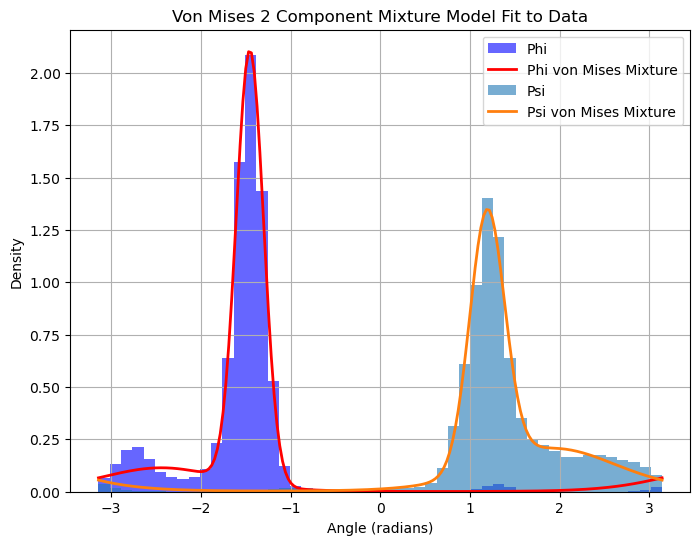

In [83]:
# Generate a smooth curve for the estimated von Mises mixture distribution
theta = np.linspace(-np.pi, np.pi, 200)  # Angle range from -π to π

# Phi
# Plot histogram of sample data
plt.figure(figsize=(8, 6))
plt.hist(phi_data, bins=50, density=True, alpha=0.6, color='b', label="Phi")

# Plot estimated von Mises Mixture Model PDF
plt.plot(theta, phi_vm_mixture.pdf(theta), 'r-', lw=2, label="Phi von Mises Mixture")

# Psi
# Plot histogram of sample data
plt.hist(psi_data, bins=50, density=True, alpha=0.6, label="Psi")

# Plot estimated von Mises Mixture Model PDF
plt.plot(theta, psi_vm_mixture.pdf(theta), lw=2, label="Psi von Mises Mixture")

# Formatting the plot
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Von Mises 2 Component Mixture Model Fit to Data")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [84]:
# Fit a 3-component von Mises mixture model to the data
phi_vm_mixture = VonMisesMixtureEM(n_components=3, max_iter=50)
phi_data = np.radians(phi.results.angles).reshape(-1,)
phi_cluster_ids, phi_ll = phi_vm_mixture.fit(phi_data)

# Convert means back to degrees for interpretation
means_degrees_opt = np.degrees(phi_means_opt)

# Display the estimated parameters
phi_ll, phi_vm_mixture.weights, phi_vm_mixture.means, phi_vm_mixture.kappas

(-558141.9089084499,
 array([0.84387138, 0.14224131, 0.01388731]),
 array([-1.46079411, -2.63573989,  1.29229773]),
 array([35.58885685, 10.31017114, 44.02689695]))

In [88]:
# Fit a 3-component von Mises mixture model to the data
psi_data = np.radians(psi.results.angles).reshape(-1,)
n_attempts = 10
obj_list = []
psi_ll = np.empty(n_attempts)
for attempt in range(n_attempts):
    obj_list.append(VonMisesMixtureEM(n_components=3, max_iter=50))
    psi_cluster_ids, psi_ll[attempt] = obj_list[attempt].fit(psi_data)
    print(psi_ll[attempt])
psi_vm_mixture = obj_list[np.argmax(psi_ll)]
# Display the estimated parameters
psi_ll, psi_vm_mixture.weights, psi_vm_mixture.means, psi_vm_mixture.kappas

-2177365.009052362
-2201768.2460537236
-2181807.7799777095
-2184906.196092235
-2201247.5203971127
-2201164.407955674
-2179085.4489806476
-2170563.98022312
-2203209.7630505566
-2200490.502039217


(array([-2177365.00905236, -2201768.24605372, -2181807.77997771,
        -2184906.19609223, -2201247.52039711, -2201164.40795567,
        -2179085.44898065, -2170563.98022312, -2203209.76305056,
        -2200490.50203922]),
 array([0.04627454, 0.28018985, 0.67353561]),
 array([0.33712432, 2.20705633, 1.19756106]),
 array([ 1.10338231,  3.56924088, 22.22871169]))

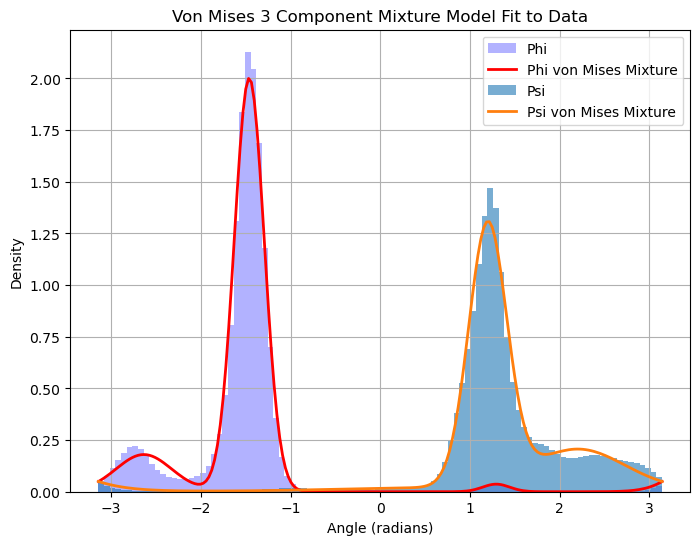

In [97]:
# Generate a smooth curve for the estimated von Mises mixture distribution
theta = np.linspace(-np.pi, np.pi, 200)  # Angle range from -π to π

# Phi
# Plot histogram of sample data
plt.figure(figsize=(8, 6))
plt.hist(phi_data, bins=100, density=True, alpha=0.3, color='b', label="Phi")

# Plot estimated von Mises Mixture Model PDF
plt.plot(theta, phi_vm_mixture.pdf(theta), 'r-', lw=2, label="Phi von Mises Mixture")

# Psi
# Plot histogram of sample data
plt.hist(psi_data, bins=100, density=True, alpha=0.6, label="Psi")

# Plot estimated von Mises Mixture Model PDF
plt.plot(theta, psi_vm_mixture.pdf(theta), lw=2, label="Psi von Mises Mixture")

# Formatting the plot
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Von Mises 3 Component Mixture Model Fit to Data")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [101]:
# Fit a 4-component von Mises mixture model to the data
psi_data = np.radians(psi.results.angles).reshape(-1,)
n_attempts = 10
obj_list = []
psi_ll = np.empty(n_attempts)
for attempt in range(n_attempts):
    obj_list.append(VonMisesMixtureEM(n_components=4, max_iter=50))
    psi_cluster_ids, psi_ll[attempt] = obj_list[attempt].fit(psi_data)
    print(psi_ll[attempt])
psi_vm_mixture = obj_list[np.argmax(psi_ll)]
# Display the estimated parameters
psi_ll, psi_vm_mixture.weights, psi_vm_mixture.means, psi_vm_mixture.kappas

-2172093.007065888
-2169529.535011261
-2176595.6643482754
-2175002.4384309603
-2171387.1782905287
-2201286.7059250586
-2178378.7641519685
-2169698.008234937
-2171732.647533124
-2199858.3784455378


(array([-2172093.00706589, -2169529.53501126, -2176595.66434828,
        -2175002.43843096, -2171387.17829053, -2201286.70592506,
        -2178378.76415197, -2169698.00823494, -2171732.64753312,
        -2199858.37844554]),
 array([0.25077734, 0.0596098 , 0.42679495, 0.26281791]),
 array([1.20800427, 0.78446435, 1.19829085, 2.22660818]),
 array([12.55384456,  0.9399206 , 32.22526097,  3.617647  ]))

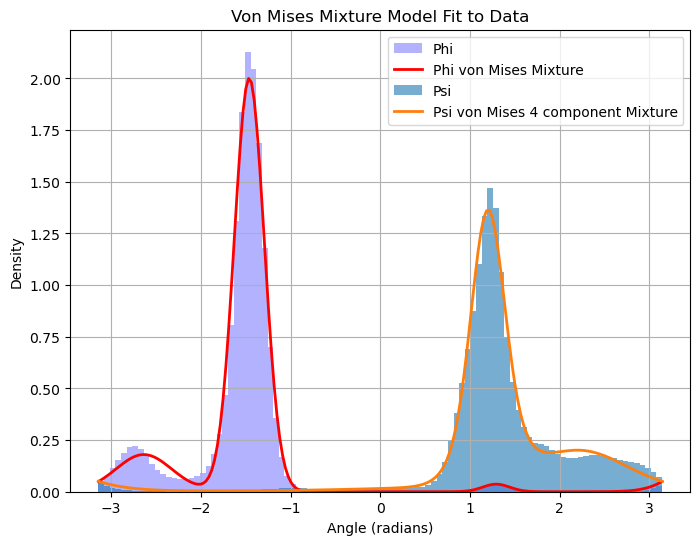

In [102]:
# Generate a smooth curve for the estimated von Mises mixture distribution
theta = np.linspace(-np.pi, np.pi, 200)  # Angle range from -π to π

# Phi
# Plot histogram of sample data
plt.figure(figsize=(8, 6))
plt.hist(phi_data, bins=100, density=True, alpha=0.3, color='b', label="Phi")

# Plot estimated von Mises Mixture Model PDF
plt.plot(theta, phi_vm_mixture.pdf(theta), 'r-', lw=2, label="Phi von Mises Mixture")

# Psi
# Plot histogram of sample data
plt.hist(psi_data, bins=100, density=True, alpha=0.6, label="Psi")

# Plot estimated von Mises Mixture Model PDF
plt.plot(theta, psi_vm_mixture.pdf(theta), lw=2, label="Psi von Mises 4 component Mixture")

# Formatting the plot
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Von Mises Mixture Model Fit to Data")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [121]:
# Fit a 4-component von Mises mixture model to the data
psi_data = np.radians(psi.results.angles).reshape(-1,)
n_attempts = 20
components = np.array([1,2,3,4,5,6,7,8,9,10])
obj_list = []
psi_ll = np.empty(components.size)
for i, component in enumerate(components):
    obj_list_temp = []
    ll = np.empty(n_attempts)
    for attempt in range(n_attempts):
        obj_list_temp.append(VonMisesMixtureEM(n_components=component, max_iter=50))
        psi_cluster_ids, ll[attempt] = obj_list_temp[attempt].fit(psi_data)
        print(component, ll[attempt])
    obj_list.append(obj_list_temp[np.argmax(ll)])
    psi_ll[i] = np.amax(ll)

1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
1 -2887337.6508581704
2 -2201541.578132837
2 -2201541.7371350345
2 -2201541.6483980548
2 -2201541.5312875365
2 -2201541.5931642377
2 -2201541.6215111283
2 -2201541.7030315404
2 -2201541.4898863514
2 -2201542.4864174593
2 -2201541.6553976997
2 -2201541.5871105585
2 -2201541.6537968633
2 -2201540.8652423113
2 -2201541.701922825
2 -2201541.6023554173
2 -2201541.6016339315
2 -2201541.7185922367
2 -2201541.6434941916
2 -2201541.6489720074
2 -2201541.7362122363
3 -2181565.972730731
3 -2178447.3997799517
3 -2179034.766895298
3 -2200113.0373852015
3 -2199577.277531803
3 -2204190.3315

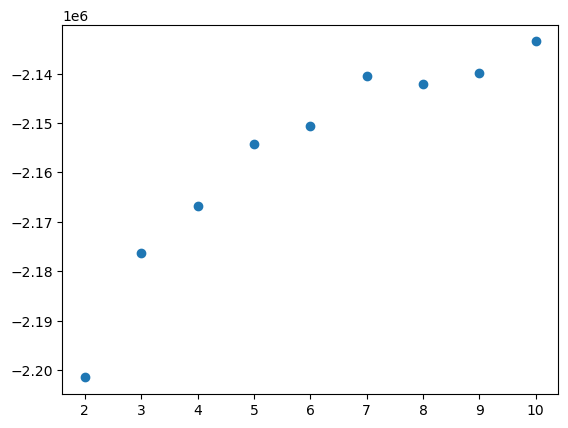

In [112]:
plt.plot(components, psi_ll,'o')

In [119]:
def bic_1d_vonmises(ll, n_components, n_frames):
    return n_components*3*np.log(n_frames) - 2*ll
def aic_1d_vonmises(ll, n_components):
    return 6*n_components - 2*ll
def icl(vonmises_mm_obj, ll, data):
    """Integrated completed likelihood (McNicholas eq 4 and need to read citations)"""
    n_frames = data.shape[0]
    responsibilities = vonmises_mm_obj.e_step(data)
    temp = np.sum(np.amax(responsibilities,axis=1))
    return vonmises_mm_obj.n_components*3*np.log(n_frames) - 2*ll - 2*temp

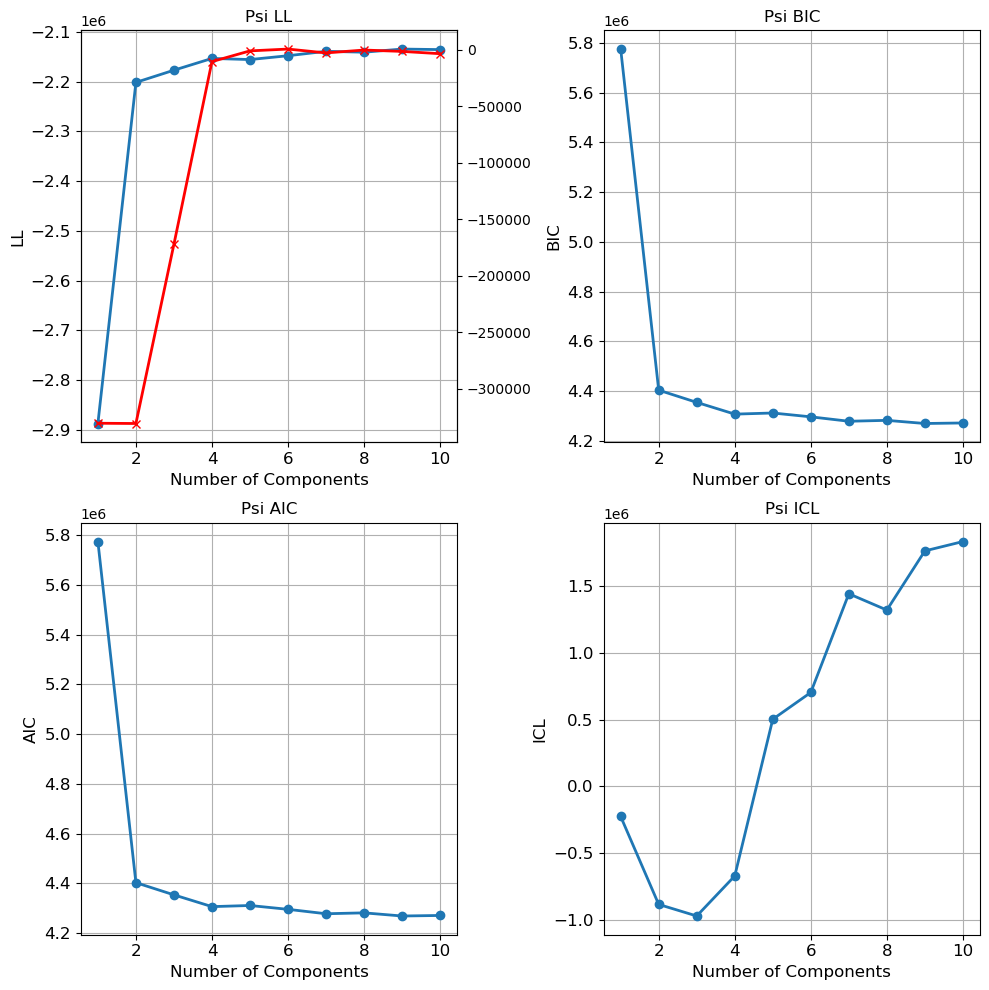

In [131]:
# Create the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10)) # 2 row, 2 columns

fontsize=12
# LL
axes[0,0].plot(components, psi_ll, '-o', lw=2)
axes[0,0].set_title('Psi LL', fontsize=fontsize)
axes[0,0].set_xlabel('Number of Components',fontsize=fontsize)
axes[0,0].set_ylabel('LL',fontsize=fontsize)
axes[0,0].grid(True)
axes[0,0].tick_params(axis='both', labelsize=fontsize)
sax = axes[0,0].twinx()
second_derivative = np.gradient(np.gradient(psi_ll))
sax.plot(components, second_derivative,'-x',c='r',lw=2)

# BIC
axes[0,1].plot(components, bic_1d_vonmises(psi_ll, components.size, psi_data.shape[0]), '-o', lw=2)
axes[0,1].set_title('Psi BIC',fontsize=fontsize)
axes[0,1].set_xlabel('Number of Components',fontsize=fontsize)
axes[0,1].set_ylabel('BIC',fontsize=fontsize)
axes[0,1].grid(True)
axes[0,1].tick_params(axis='both', labelsize=fontsize)

# AIC
axes[1,0].plot(components, aic_1d_vonmises(psi_ll, components.size), '-o', lw=2)
axes[1,0].set_title('Psi AIC',fontsize=fontsize)
axes[1,0].set_xlabel('Number of Components',fontsize=fontsize)
axes[1,0].set_ylabel('AIC',fontsize=fontsize)
axes[1,0].grid(True)
axes[1,0].tick_params(axis='both', labelsize=fontsize)

# ICL
icl_c = np.empty(components.size)
for i, component in enumerate(components):
    icl_c[i] = icl(obj_list[i], psi_ll[i], psi_data)
axes[1,1].plot(components, icl_c, '-o', lw=2)
axes[1,1].set_title('Psi ICL',fontsize=fontsize)
axes[1,1].set_xlabel('Number of Components',fontsize=fontsize)
axes[1,1].set_ylabel('ICL',fontsize=fontsize)
axes[1,1].grid(True)
axes[1,1].tick_params(axis='both', labelsize=fontsize)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

In [123]:
# Fit a 4-component von Mises mixture model to the data
phi_data = np.radians(phi.results.angles).reshape(-1,)
n_attempts = 20
components = np.array([1,2,3,4,5,6,7,8,9,10])
phi_obj_list = []
phi_ll = np.empty(components.size)
for i, component in enumerate(components):
    obj_list_temp = []
    ll = np.empty(n_attempts)
    for attempt in range(n_attempts):
        obj_list_temp.append(VonMisesMixtureEM(n_components=component, max_iter=50))
        psi_cluster_ids, ll[attempt] = obj_list_temp[attempt].fit(phi_data)
        print(component, ll[attempt])
    phi_obj_list.append(obj_list_temp[np.argmax(ll)])
    phi_ll[i] = np.amax(ll)

1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
1 -2226268.20664565
2 -721566.4598039931
2 -721566.4596729693
2 -721566.4598623319
2 -721566.4597415309
2 -721566.4598077231
2 -721566.459826207
2 -721566.459827081
2 -721566.4598327058
2 -721566.4597591102
2 -721566.4597384416
2 -721566.4597625085
2 -721566.459212406
2 -721566.4597660588
2 -721566.4598279246
2 -721566.459760264
2 -721566.4597335318
2 -721566.4598356417
2 -721566.4596212221
2 -721566.4598625051
2 -721566.4596666956
3 -720613.3228748826
3 -720602.6149845658
3 -558141.4813403252
3 -720613.7231721472
3 -720605.8886528371
3 -720588.3006636426
3 -720612.8569984498
3 -720708.5204034565
3 -720674.732145

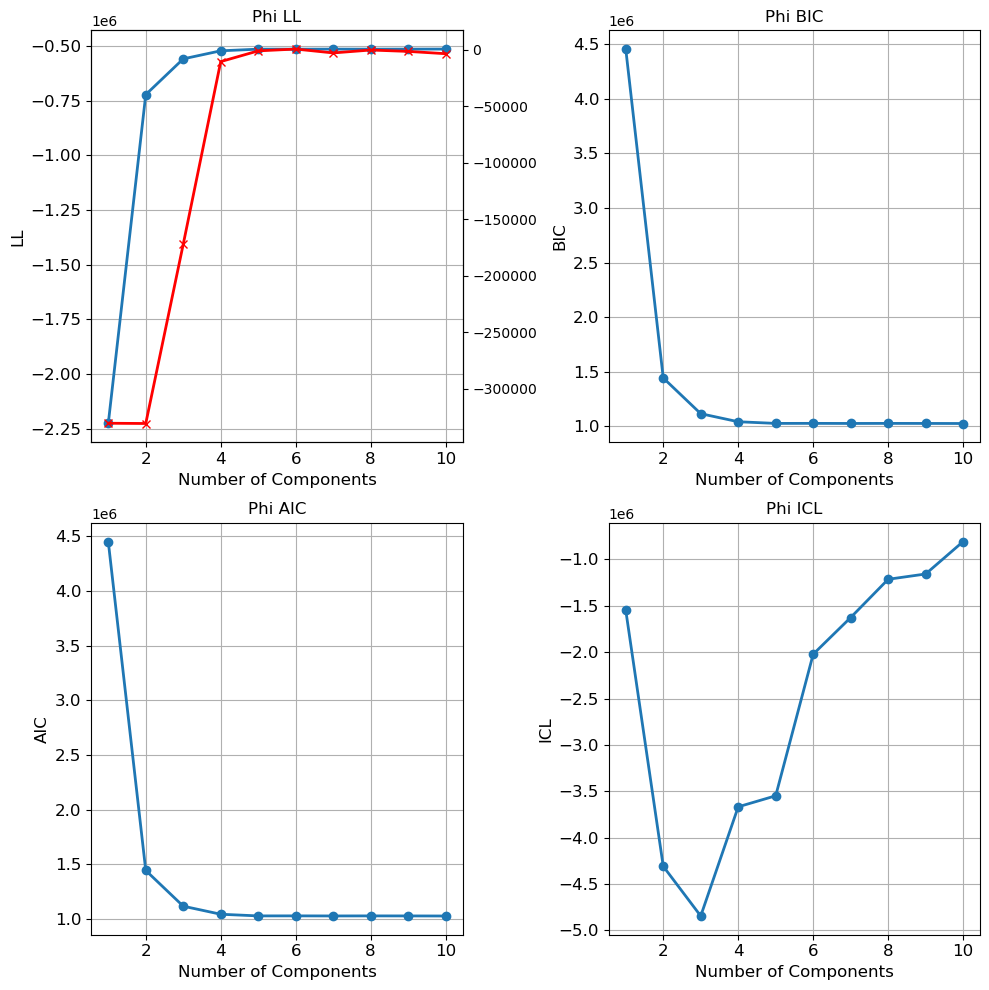

In [132]:
# Create the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10)) # 2 row, 2 columns

fontsize=12
# LL
axes[0,0].plot(components, phi_ll, '-o', lw=2)
axes[0,0].set_title('Phi LL', fontsize=fontsize)
axes[0,0].set_xlabel('Number of Components',fontsize=fontsize)
axes[0,0].set_ylabel('LL',fontsize=fontsize)
axes[0,0].grid(True)
axes[0,0].tick_params(axis='both', labelsize=fontsize)
sax = axes[0,0].twinx()
second_derivative = np.gradient(np.gradient(psi_ll))
sax.plot(components, second_derivative,'-x',c='r',lw=2)

# BIC
axes[0,1].plot(components, bic_1d_vonmises(phi_ll, components.size, phi_data.shape[0]), '-o', lw=2)
axes[0,1].set_title('Phi BIC',fontsize=fontsize)
axes[0,1].set_xlabel('Number of Components',fontsize=fontsize)
axes[0,1].set_ylabel('BIC',fontsize=fontsize)
axes[0,1].grid(True)
axes[0,1].tick_params(axis='both', labelsize=fontsize)

# AIC
axes[1,0].plot(components, aic_1d_vonmises(phi_ll, components.size), '-o', lw=2)
axes[1,0].set_title('Phi AIC',fontsize=fontsize)
axes[1,0].set_xlabel('Number of Components',fontsize=fontsize)
axes[1,0].set_ylabel('AIC',fontsize=fontsize)
axes[1,0].grid(True)
axes[1,0].tick_params(axis='both', labelsize=fontsize)

# ICL
icl_c = np.empty(components.size)
for i, component in enumerate(components):
    icl_c[i] = icl(phi_obj_list[i], phi_ll[i], phi_data)
axes[1,1].plot(components, icl_c, '-o', lw=2)
axes[1,1].set_title('Phi ICL',fontsize=fontsize)
axes[1,1].set_xlabel('Number of Components',fontsize=fontsize)
axes[1,1].set_ylabel('ICL',fontsize=fontsize)
axes[1,1].grid(True)
axes[1,1].tick_params(axis='both', labelsize=fontsize)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

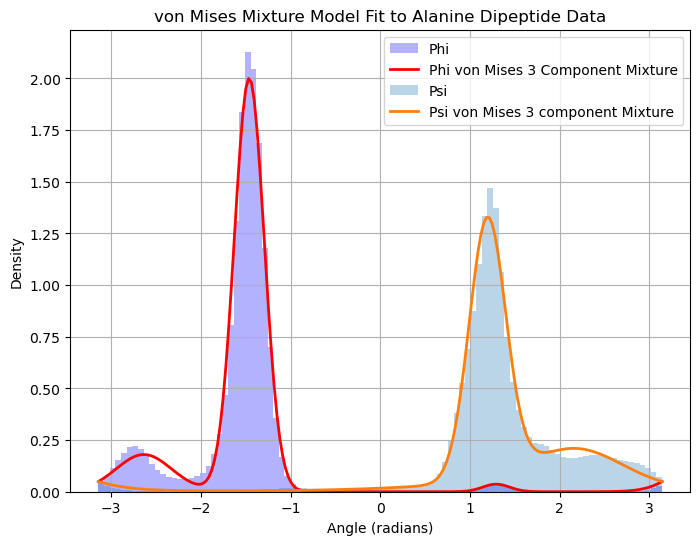

In [130]:
# Generate a smooth curve for the estimated von Mises mixture distribution
theta = np.linspace(-np.pi, np.pi, 200)  # Angle range from -π to π

# Phi
# Plot histogram of sample data
plt.figure(figsize=(8, 6))
plt.hist(phi_data, bins=100, density=True, alpha=0.3, color='b', label="Phi")

# Plot estimated von Mises Mixture Model PDF
plt.plot(theta, phi_obj_list[2].pdf(theta), 'r-', lw=2, label="Phi von Mises 3 Component Mixture")

# Psi
# Plot histogram of sample data
plt.hist(psi_data, bins=100, density=True, alpha=0.3, label="Psi")

psi_vm_mixture = obj_list[2]
# Plot estimated von Mises Mixture Model PDF
plt.plot(theta, psi_vm_mixture.pdf(theta), lw=2, label="Psi von Mises 3 component Mixture")

# Formatting the plot
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("von Mises Mixture Model Fit to Alanine Dipeptide Data")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

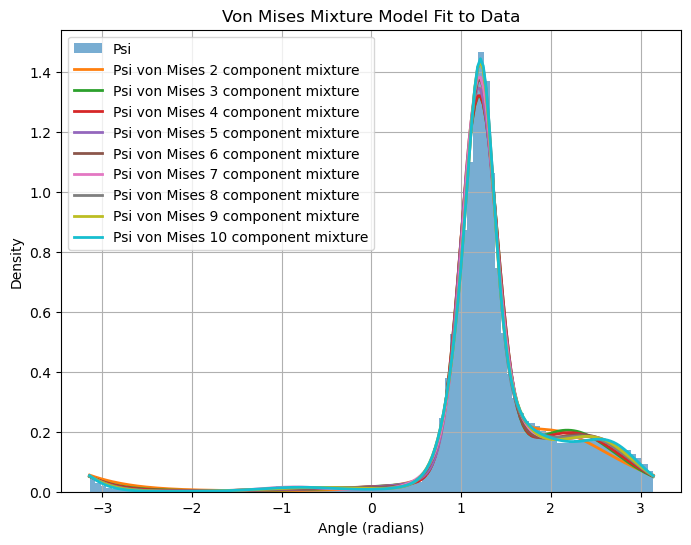

In [113]:
# Generate a smooth curve for the estimated von Mises mixture distribution
theta = np.linspace(-np.pi, np.pi, 200)  # Angle range from -π to π

# Psi
# Plot histogram of sample data
plt.figure(figsize=(8, 6))
plt.hist(psi_data, bins=100, density=True, alpha=0.6, label="Psi")

for i, component in enumerate(components):
    label = "Psi von Mises " + str(component) + " component mixture"
    plt.plot(theta, obj_list[i].pdf(theta), lw=2, label=label)
# Formatting the plot
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Von Mises Mixture Model Fit to Data")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

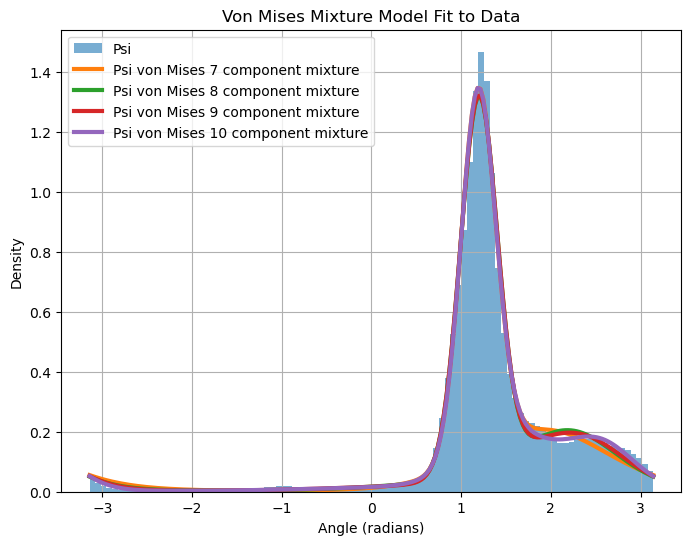

In [115]:
# Generate a smooth curve for the estimated von Mises mixture distribution
theta = np.linspace(-np.pi, np.pi, 200)  # Angle range from -π to π

# Psi
# Plot histogram of sample data
plt.figure(figsize=(8, 6))
plt.hist(psi_data, bins=100, density=True, alpha=0.6, label="Psi")

for i, component in enumerate(components[5:]):
    label = "Psi von Mises " + str(component) + " component mixture"
    plt.plot(theta, obj_list[i].pdf(theta), lw=3, label=label)
# Formatting the plot
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Von Mises Mixture Model Fit to Data")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

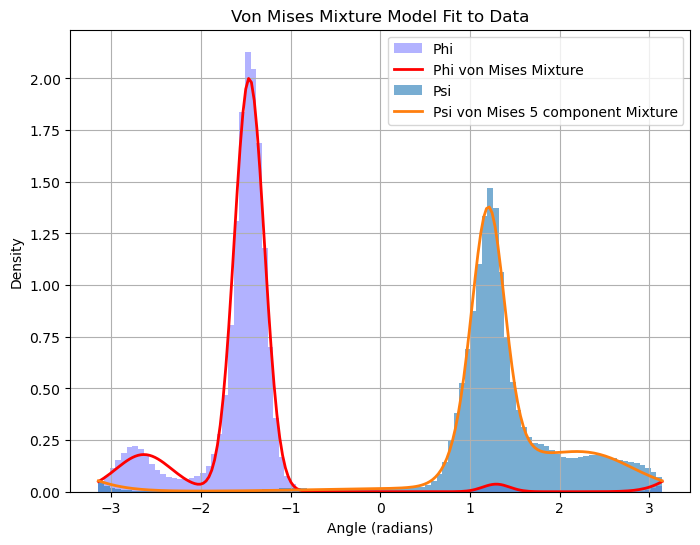

In [105]:
# Generate a smooth curve for the estimated von Mises mixture distribution
theta = np.linspace(-np.pi, np.pi, 200)  # Angle range from -π to π

# Phi
# Plot histogram of sample data
plt.figure(figsize=(8, 6))
plt.hist(phi_data, bins=100, density=True, alpha=0.3, color='b', label="Phi")

# Plot estimated von Mises Mixture Model PDF
plt.plot(theta, phi_vm_mixture.pdf(theta), 'r-', lw=2, label="Phi von Mises Mixture")

# Psi
# Plot histogram of sample data
plt.hist(psi_data, bins=100, density=True, alpha=0.6, label="Psi")

psi_vm_mixture = obj_list[-1]
# Plot estimated von Mises Mixture Model PDF
plt.plot(theta, psi_vm_mixture.pdf(theta), lw=2, label="Psi von Mises 5 component Mixture")

# Formatting the plot
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Von Mises Mixture Model Fit to Data")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [55]:
np.savetxt("phi_psi_angles.txt", np.column_stack((phi_data[::15],psi_data[::15])))

In [56]:
np.savetxt("phi_psi_angles.csv", np.column_stack((phi_data[::15],psi_data[::15])),delimiter=",")

/var/folders/td/dll8n_kj4vd0zxjm0xd9m7740000gq/T/ipykernel_80103/910894870.py:9: RuntimeWarning: divide by zero encountered in log
  fe = -np.log(hist)


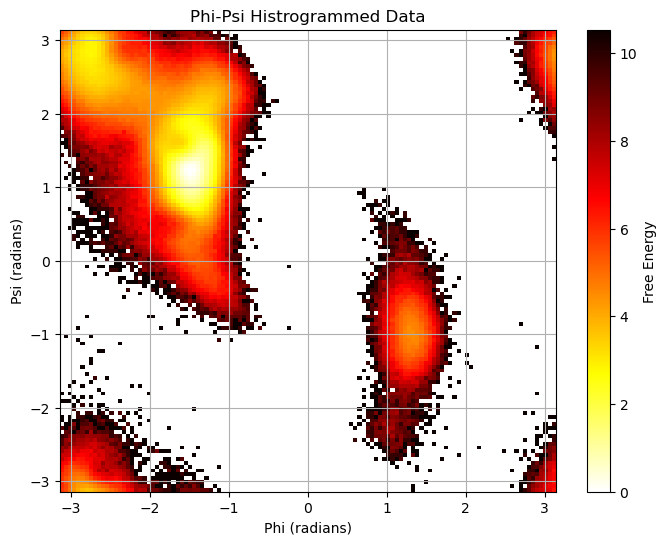

In [139]:
# Manually convert the pasted data into a NumPy array
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D normalized histogram
plt.figure(figsize=(8, 6))
hist, xedges, yedges = np.histogram2d(phi_data, psi_data, bins=120, density=True)
y, x = np.meshgrid(xedges,yedges)
fe = -np.log(hist)
fe -= np.amin(fe)
plt.pcolormesh(x,y,fe, cmap='hot_r')
#plt.scatter(phi_data[::100],psi_data[::100],s=0.1)

# Add color bar
plt.colorbar(label="Free Energy")

# Formatting the plot
plt.xlabel("Phi (radians)")
plt.ylabel("Psi (radians)")
plt.title("Phi-Psi Histrogrammed Data")
plt.grid(True)

# Show the plot
plt.show()


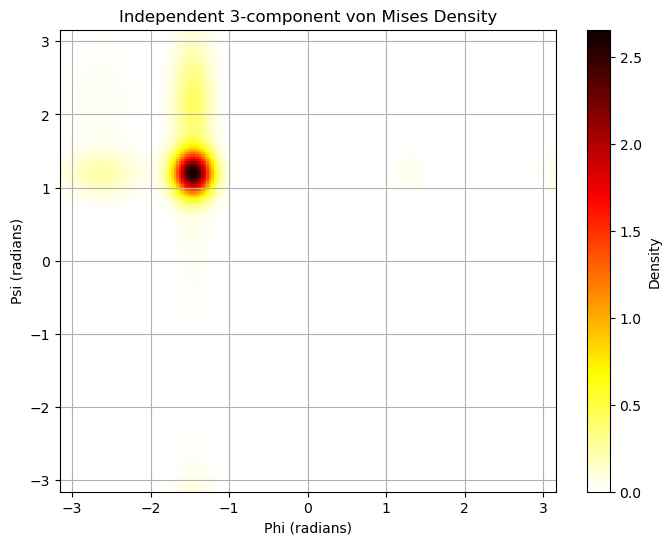

In [143]:
# Create a 2D normalized histogram
plt.figure(figsize=(8, 6))

phi_mesh, psi_mesh = np.meshgrid(theta,theta)

def von_mises_2d(x, y, von_mises_1, von_mises_2):
    return von_mises_1.pdf(x)*von_mises_2.pdf(y)

Z = von_mises_2d(phi_mesh,psi_mesh,phi_vm_mixture, psi_vm_mixture)
fe = -np.log(Z)
fe -= np.amin(fe)
plt.pcolormesh(phi_mesh, psi_mesh, Z, cmap='hot_r')


# Add color bar
plt.colorbar(label="Density")

# Formatting the plot
plt.xlabel("Phi (radians)")
plt.ylabel("Psi (radians)")
plt.title("Independent 3-component von Mises Density")
plt.grid(True)

# Show the plot
plt.show()